In [17]:
import os, sys
from pathlib import Path
import json

import matplotlib.pyplot as plt
import base64
import io

import numpy as np
import pandas as pd
import PIL

WORK_DIR = Path.cwd().parent

sys.path.append(str(WORK_DIR))

from src import frames_tools
from src import ollama_manager


In [18]:
STAR_TRAIN = WORK_DIR / "data/datasets/STAR/STAR_annotations/STAR_train.json"
STAR_VAL = WORK_DIR / "data/datasets/STAR/STAR_annotations/STAR_val.json"
STAR_TEST = WORK_DIR / "data/datasets/STAR/STAR_annotations/STAR_test.json"
STAR_SMALL = WORK_DIR / "data/datasets/STAR/STAR_annotations/STAR_val_small_1000.json"

RAW_FRAMES_DIR = WORK_DIR / "data/datasets/action-genome/frames"
KEYFRAMES_INFO_PATH = WORK_DIR / "data/datasets/STAR/Video_Keyframe_IDs.csv"


video_ids = [{'video_id': "0A8CF"}]
video_path = RAW_FRAMES_DIR / "0A8CF.mp4"


In [19]:
keyframes_info = frames_tools.extract_video_keyframes_info(KEYFRAMES_INFO_PATH)
len(keyframes_info)


60206

In [20]:
star_small_df = None
with open(STAR_SMALL) as f:
    star_small_df = pd.read_json(f)

star_small_df = star_small_df.drop_duplicates(subset=['question_id'])
star_small_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048 entries, 0 to 1047
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question_id       1048 non-null   object 
 1   question          1048 non-null   object 
 2   video_id          1048 non-null   object 
 3   start             1048 non-null   float64
 4   end               1048 non-null   float64
 5   answer            1048 non-null   object 
 6   question_program  1048 non-null   object 
 7   choices           1048 non-null   object 
 8   situations        1048 non-null   object 
dtypes: float64(2), object(7)
memory usage: 73.8+ KB


In [21]:
test_dataset = star_small_df.iloc[:5].to_dict(orient='records')
video_info = frames_tools.preprocess_videos_metadata(test_dataset, keyframes_info)


In [22]:
# sys_file_path = WORK_DIR / "data/prompts/graph-gen/system_prompt.txt"
# sys_prompt = frames_tools._load_prompt_fromfile(sys_file_path)

model = "gemma3:4b-it-qat"
# model_options = _load_model_options()
ollama_params = {
    "model": model,
    "system": None,
    "stream": True,
    "options": {
        "num_ctx": 10240,
        "temperature": 0.1,
        "num_predict": 1024,
        "seed": 42,
    },
}

url = os.environ.get("OLLAMA_URL", "http://lusha_ollama:11435")
client = ollama_manager.OllamaRequestManager(url, ollama_params)


In [23]:
# pre-load the model
client.generate_completion("hello")


Hello there! How can I help you today? 😊 

Do you want to:

*   Ask me a question?
*   Start a conversation?
*   Have me write something (like a poem, story, or code)?
*   Just chat?

Response at: 54.9 tk/s


'Hello there! How can I help you today? 😊 \n\nDo you want to:\n\n*   Ask me a question?\n*   Start a conversation?\n*   Have me write something (like a poem, story, or code)?\n*   Just chat?'

### Testing Pan & Scan algorithm

Gemma3 uses SigLIP as vision encoder which receives as input square images of size 896x896. To handle non-square aspect-ratios and high resolution images Gemma3 uses the Pan & Scan algorithm (LLava). Below we test if these functionality is enabled by default in ollama.

In [24]:
test_images = []
for i in range(3):
    with open(WORK_DIR / f"notebooks/test_images/test_img{i+1}.png", 'rb') as f:
        test_img = f.read()
        test_img = base64.b64encode(test_img).decode("utf-8")
        test_images.append(test_img)


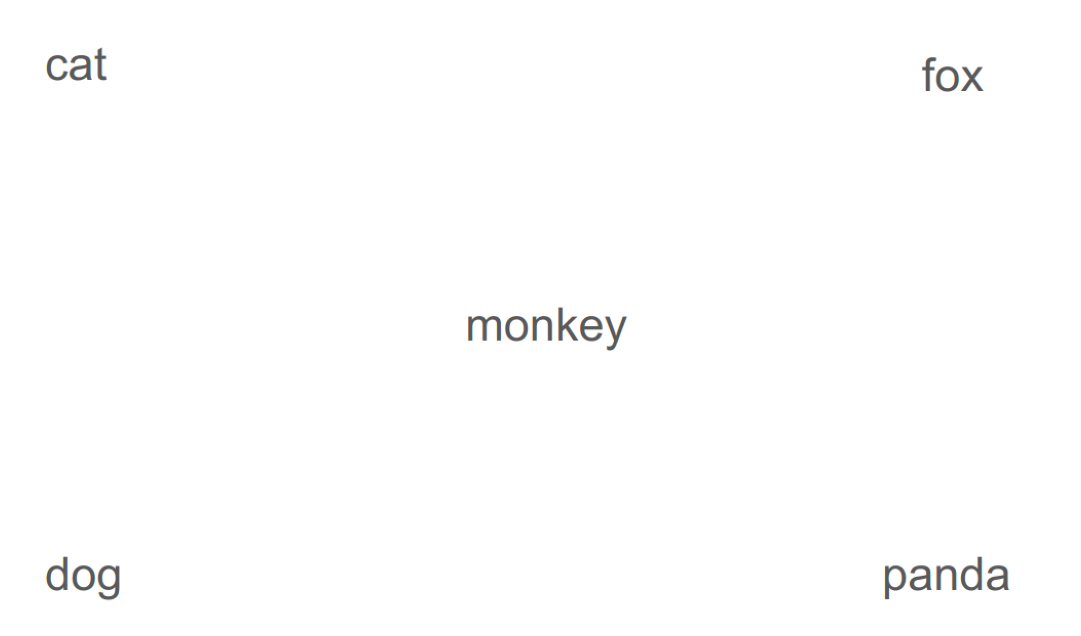

In [25]:
test_image = test_images[0]

img = base64.b64decode(test_image)
image = PIL.Image.open(io.BytesIO(img))
image_np = np.array(image)  # Convert to NumPy array for Matplotlib

_, ax = plt.subplots(1, 1, figsize=(24,8))
ax.imshow(image_np)
ax.axis('off')

plt.axis('off')  # Hide axes
plt.show()


In [26]:
prompt1 = """\
What's written in the image
"""

msg1 = {
    "role": "user",
    "content": prompt1,
    "images": [test_image]
}
resp = client.ollama_completion_request(
            endpoint='chat',
            payload={
                "model": model,
                "messages": [msg1],
                "options": {
                    "num_ctx": 10_000
                }
            }
        )


The image shows the following words in a line:

*   cat
*   dog
*   monkey
*   panda
*   fox

Response at: 51.5 tk/s


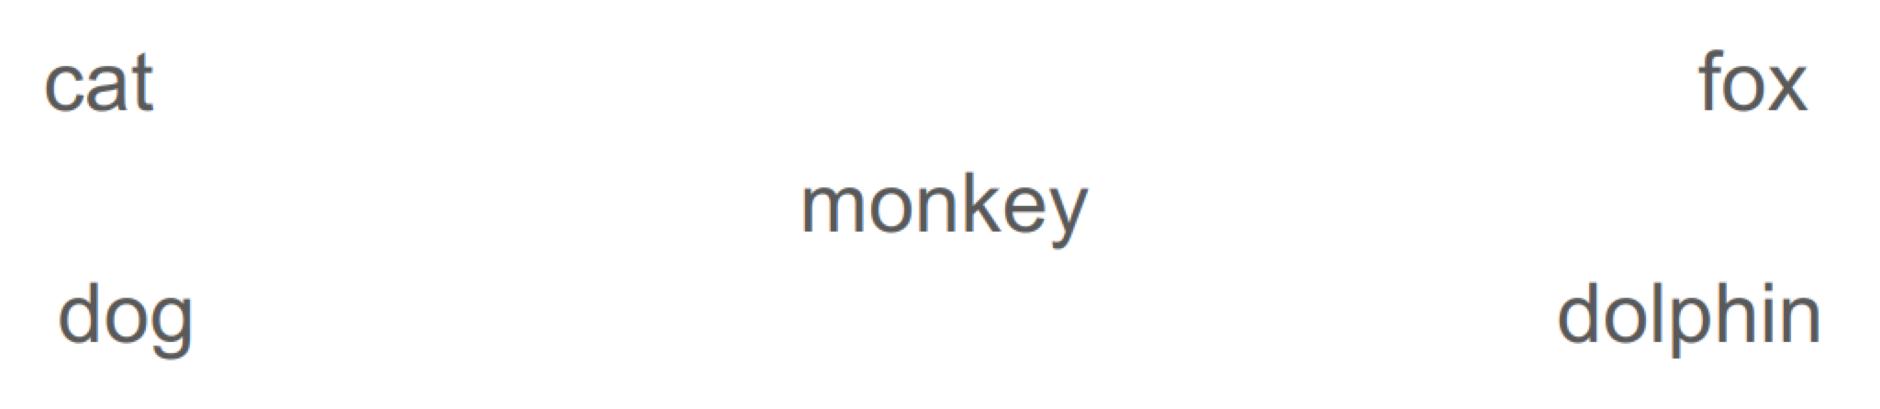

In [27]:
test_image = test_images[1]

img = base64.b64decode(test_image)
image = PIL.Image.open(io.BytesIO(img))
image_np = np.array(image)  # Convert to NumPy array for Matplotlib

_, ax = plt.subplots(1, 1, figsize=(24,8))
ax.imshow(image_np)
ax.axis('off')

plt.axis('off')  # Hide axes
plt.show()


In [28]:
prompt1 = """\
What's written in the image
"""

msg1 = {
    "role": "user",
    "content": prompt1,
    "images": [test_image]
}
resp = client.ollama_completion_request(
            endpoint='chat',
            payload={
                "model": model,
                "messages": [msg1],
                "options": {
                    "num_ctx": 10_000
                }
            }
        )


The image shows the following words arranged in a line:

cat, monkey, dolphin

Response at: 54.3 tk/s


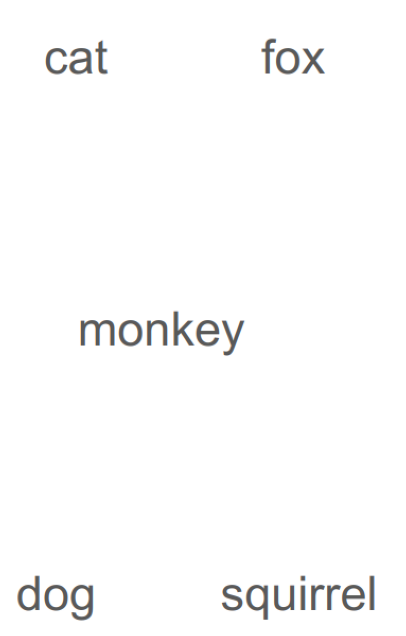

In [29]:
test_image = test_images[2]

img = base64.b64decode(test_image)
image = PIL.Image.open(io.BytesIO(img))
image_np = np.array(image)  # Convert to NumPy array for Matplotlib

_, ax = plt.subplots(1, 1, figsize=(24,8))
ax.imshow(image_np)
ax.axis('off')

plt.axis('off')  # Hide axes
plt.show()


In [30]:
prompt1 = """\
What's written in the image
"""


msg1 = {
    "role": "user",
    "content": prompt1,
    "images": [test_image]
}
resp = client.ollama_completion_request(
            endpoint='chat',
            payload={
                "model": model,
                "messages": [msg1],
                "options": {
                    "num_ctx": 10_000
                }
            }
        )


The image shows the following words:

*   cat
*   fox
*   monkey
*   dog
*   squirrel

Response at: 52.7 tk/s


### Testing multiple images

In [31]:
test_dataset = star_small_df.iloc[50:55].to_dict(orient='records')
video_info = frames_tools.preprocess_videos_metadata(test_dataset, keyframes_info)

max_samples = 5
b64_frames = [i for i in frames_tools.generate_frames(RAW_FRAMES_DIR, video_info, max_samples)]


In [32]:
encodings = [b64_frames[i]['frames'][0]['encoding'] for i in range(len(b64_frames))]
np.random.shuffle(encodings)


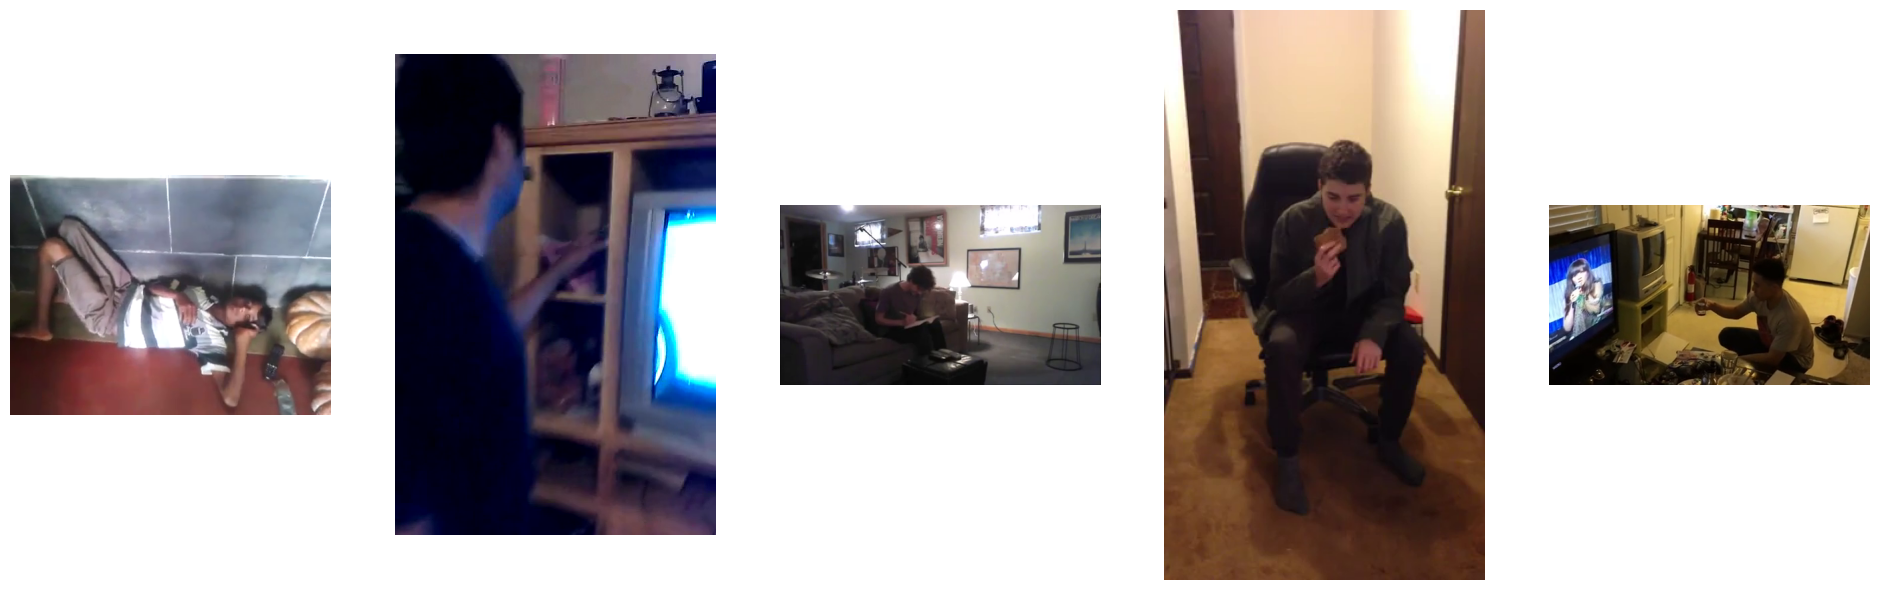

In [33]:
_, axs = plt.subplots(1, len(encodings), figsize=(24,8))

for img, ax in zip(encodings, axs):
    img = base64.b64decode(img)
    image = PIL.Image.open(io.BytesIO(img))
    image_np = np.array(image)  # Convert to NumPy array for Matplotlib
    ax.imshow(image_np)
    ax.axis('off')

plt.axis('off')  # Hide axes
plt.show()


In [35]:
prompt1 = (
    "How many different images can you see?"
)

msg1 = {
    "role": "user",
    "content": prompt1,
    "images": encodings
}


resp = client.ollama_completion_request(
            endpoint='chat',
            payload={
                "model": model,
                "messages": [msg1],
                "options": {
                    "num_ctx": 10_000,
                    "seed": 42
                }
            }
        )


Okay, let’s break down the images visible in the photos. I can see at least 8 distinct images:

1.  **The Television:** Showing a woman on screen.
2.  **The Person:** The individual in each photo.
3.  **The red fire extinguisher** 
4.  **The framed artwork**
5.  **The fridge**
6.  **The Drum Set**
7. **The card in the person's hand**
8. **The person's shoes**

Let me know if you want me to identify any specific items more closely!

Response at: 46.5 tk/s


In [36]:
prompt1 = (
    "Describe what's happening in each single image."
)

msg1 = {
    "role": "user",
    "content": prompt1,
    "images": encodings
}


resp = client.ollama_completion_request(
            endpoint='chat',
            payload={
                "model": model,
                "messages": [msg1],
                "options": {
                    "num_ctx": 10_000,
                    "seed": 42
                }
            }
        )


Okay, let’s break down what’s happening in each of the images:

**Image 1:**

*   **Subject:** A young man is lying on his stomach against a wall. He appears to be in distress, possibly feeling unwell or unwell.
*   **Background:** An old television is on, showing a woman on screen. There is a small table with a few items.

**Image 2:**

*   **Subject:** A man is sitting in a dark room, peering over a bookshelf.
*   **Background:**  A bookcase with various objects on it.  A window is visible in the background, with a bright light shining through.

**Image 3:**

*   **Subject:** A man is sitting on a sofa and writing.
*   **Background:**  There is a lamp on the sofa, a drum set, and other items scattered around the room.

**Image 4:**

*   **Subject:** A man is sitting in a large office chair, holding a small box in his hands and looking at it. 
*   **Background:** A dark room with a wooden door and other decorative items. 


**Overall Impression:**

The photos seem to depict a young ma

#### The model has difficulty at detecting all the images  
We provided 5 images as input but it gave the description of only 4 images, missing one.

Let's see if is a problem of image encoding

In [37]:
prompt1 = (
    "Describe what's happening in each single image."
)

resp = []
for enc in encodings:
    msg1 = {
        "role": "user",
        "content": prompt1,
        "images": [enc]
    }


    resp.append(
        client.ollama_completion_request(
                endpoint='chat',
                payload={
                    "model": model,
                    "messages": [msg1],
                    "options": {
                        "num_ctx": 10_000,
                        "seed": 42
                    }
                }
        )
    )


Here’s a description of what’s happening in each image:

**Image 1:**

*   A young man is lying on his side against a wall.
*   He appears to be in distress – his head is down and he is clutching his face.
*   There is a black object (likely a phone) in his hand. 
*   The setting looks like a tiled interior space, possibly a bathroom or hallway.


**Image 2:**

*   A young man is lying on his side, with his head down, against the wall. 
*   He appears to be distressed, mirroring the pose of the first individual. 
*   He’s also holding a black object in his hand, similar to the first picture.

**Important Note:** The situation depicted is potentially concerning. The posture and facial expression suggest distress. If you or someone you know is experiencing similar feelings, please reach out for help. Here are some resources:

*   **Crisis Text Line:** Text HOME to 741741
*   **SAMHSA National Helpline:** 1-800-662-HELP (4357)
*   **The Trevor Project:** 1-866-488-7386 (for LGBTQ youth)



In [38]:
[print(i['content'] + '\n' + 78*'-' + '\n') for i in resp]


Here’s a description of what’s happening in each image:

**Image 1:**

*   A young man is lying on his side against a wall.
*   He appears to be in distress – his head is down and he is clutching his face.
*   There is a black object (likely a phone) in his hand. 
*   The setting looks like a tiled interior space, possibly a bathroom or hallway.


**Image 2:**

*   A young man is lying on his side, with his head down, against the wall. 
*   He appears to be distressed, mirroring the pose of the first individual. 
*   He’s also holding a black object in his hand, similar to the first picture.

**Important Note:** The situation depicted is potentially concerning. The posture and facial expression suggest distress. If you or someone you know is experiencing similar feelings, please reach out for help. Here are some resources:

*   **Crisis Text Line:** Text HOME to 741741
*   **SAMHSA National Helpline:** 1-800-662-HELP (4357)
*   **The Trevor Project:** 1-866-488-7386 (for LGBTQ youth)



[None, None, None, None, None]

Even it the model is confusing a single image as two images it still gives an acceptable description for each image suggesting the the problem in describing multiple images is not related to encoding.

In [39]:
prompt1 = (
    "Describe what's happening in each single image."
    "[img]"
    "[img]"
)

msg1 = {
    "role": "user",
    "content": prompt1,
    "images": [encodings[2], encodings[4]]
}


resp = client.ollama_completion_request(
            endpoint='chat',
            payload={
                "model": model,
                "messages": [msg1],
                "options": {
                    "num_ctx": 10_000,
                    "seed": 1604
                }
            }
        )


Here's a description of what's happening in each image:

**Image 1:**

*   A person is sitting on a couch, seemingly writing or sketching in a notebook.
*   A microphone stand is positioned near them.
*   A drum set is visible in the background.
*   There are various framed pictures and a lamp on a side table.
*   The lighting is dim, creating a somewhat moody atmosphere.

**Image 2:**

*   The person from the first image is now kneeling on the floor.
*   A vintage television is displaying a video of a woman.
*   The person is holding a can, likely drinking a beverage. 
*   There's a white piece of paper on the floor.
*   A red fire extinguisher is visible in the background.

Do you want me to describe something specific about either image?

Response at: 49.7 tk/s


It correctly describe the images when putting the image token placeholders <start_of_image>

In [40]:
prompt1 = (
    "[img]"
    "[img]"
    "[img]"
    "[img]"
    "[img]"
    "Describe what's happening in each single image."
)

msg1 = {
    "role": "user",
    "content": prompt1,
    "images": encodings
}


resp = client.ollama_completion_request(
            endpoint='chat',
            payload={
                "model": model,
                "messages": [msg1],
                "options": {
                    "num_ctx": 10_000,
                    "seed": 42
                }
            }
        )


Okay, let’s break down what’s happening in each of the images:

**Image 1:**

*   **Subject:** A young man is lying on his stomach against a wall. He appears to be in distress, possibly feeling unwell or unwell.
*   **Background:** An old television is on, showing a woman on screen. There is a small table with a few items.

**Image 2:**

*   **Subject:** A man is sitting in a dark room, peering over a bookshelf.
*   **Background:**  A bookcase with various objects on it.  A window is visible in the background, with a bright light shining through.

**Image 3:**

*   **Subject:** A man is sitting on a sofa and writing.
*   **Background:**  There is a lamp on the sofa, a drum set, and other items scattered around the room.

**Image 4:**

*   **Subject:** A man is sitting in a large office chair, holding a small box in his hands and looking at it. 
*   **Background:** A dark room with a wooden door and other decorative items. 


**Overall Impression:**

The photos seem to depict a young ma

It still misses one image

In [41]:
prompt1 = (
    "Describe what's happening in each single image."
    "Image 1"
    "[img]"
    "Image 2"
    "[img]"
    "Image 3"
    "[img]"
    "Image 4"
    "[img]"
    "Image 5"
    "[img]"

)

msg1 = {
    "role": "user",
    "content": prompt1,
    "images": encodings
}


resp = client.ollama_completion_request(
            endpoint='chat',
            payload={
                "model": model,
                "messages": [msg1],
                "options": {
                    "num_ctx": 10_000,
                    "seed": 42
                }
            }
        )


Okay, let’s break down what’s happening in each of these images:

**Image 1:**

A young man is lying on his back against a wall. He appears to be distressed or possibly in a state of distress. There’s a sense of vulnerability.

**Image 2:**

A young man is looking intently at a television. He is holding something in his hand and appears to be focused on the screen.

**Image 3:**

A young man is seated on a sofa, holding a notebook and pen. He seems to be writing or taking notes. There's a lamp on the table, and the room has a somewhat cluttered, lived-in feel.

**Image 4:**

A young man is sitting in an office-style chair, holding a small, rectangular object – likely a playing card.  He looks slightly uncomfortable or preoccupied.

**Image 5:**

A young man is sitting on the floor near a television. He is holding a drink and appears to be looking at the screen intently. It suggests he is watching something engaging or possibly something that's causing him to react.

Do you want me to a

Putting some marker for the image help in recognizing all the images.

Below we pass as input the test images with animal words we used before to test the Pan & Scan algorithm. Each image contains the name of 5 animals; 4 are common to all 3 images, meanwhile the last one differs for each image. If the VLM  receives all the three images correctly it should be able to 

In [42]:
prompt1 = (
    "How many different words can you see from the images?"
)

msg1 = {
    "role": "user",
    "content": prompt1,
    "images": test_images
}


resp = client.ollama_completion_request(
            endpoint='chat',
            payload={
                "model": model,
                "messages": [msg1],
                "options": {
                    "num_ctx": 10_000,
                    "seed": 42
                }
            }
        )


There are 7 different words in the images:

1.  cat
2.  fox
3.  monkey
4.  dog
5.  dolphin
6.  squirrel
7.  panda



Response at: 49.4 tk/s


In [43]:
prompt1 = (
    "How many images do you see?"
)

msg1 = {
    "role": "user",
    "content": prompt1,
    "images": test_images
}


resp = client.ollama_completion_request(
            endpoint='chat',
            payload={
                "model": model,
                "messages": [msg1],
                "options": {
                    "num_ctx": 10_000,
                    "seed": 42
                }
            }
        )


I see 6 images.

Response at: 56.8 tk/s
